In [45]:
import gc

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
import umap
from plotly.subplots import make_subplots
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.feature_selection import mutual_info_classif
from sklearn.preprocessing import StandardScaler

In [2]:
train_df = pd.read_csv("data/train.csv", index_col="id")
test_df = pd.read_csv("data/test.csv", index_col="id")

In [3]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2190 entries, 0 to 2189
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   day            2190 non-null   int64  
 1   pressure       2190 non-null   float64
 2   maxtemp        2190 non-null   float64
 3   temparature    2190 non-null   float64
 4   mintemp        2190 non-null   float64
 5   dewpoint       2190 non-null   float64
 6   humidity       2190 non-null   float64
 7   cloud          2190 non-null   float64
 8   sunshine       2190 non-null   float64
 9   winddirection  2190 non-null   float64
 10  windspeed      2190 non-null   float64
 11  rainfall       2190 non-null   int64  
dtypes: float64(10), int64(2)
memory usage: 222.4 KB


In [4]:
train_df.describe()

,day,pressure,maxtemp,temparature,mintemp,dewpoint,humidity,cloud,sunshine,winddirection,windspeed,rainfall
count,2190.000000,2190.000000,2190.000000,2190.000000,2190.000000,2190.000000,2190.000000,2190.000000,2190.000000,2190.000000,2190.000000,2190.000000
mean,179.948402,1013.602146,26.365799,23.953059,22.170091,20.454566,82.036530,75.721918,3.744429,104.863151,21.804703,0.753425
std,105.203592,5.655366,5.654330,5.222410,5.059120,5.288406,7.800654,18.026498,3.626327,80.002416,9.898659,0.431116
min,1.000000,999.000000,10.400000,7.400000,4.000000,-0.300000,39.000000,2.000000,0.000000,10.000000,4.400000,0.000000
25%,89.000000,1008.600000,21.300000,19.300000,17.700000,16.800000,77.000000,69.000000,0.400000,40.000000,14.125000,1.000000
50%,178.500000,1013.000000,27.800000,25.500000,23.850000,22.150000,82.000000,83.000000,2.400000,70.000000,20.500000,1.000000
75%,270.000000,1017.775000,31.200000,28.400000,26.400000,25.000000,88.000000,88.000000,6.800000,200.000000,27.900000,1.000000
max,365.000000,1034.600000,36.000000,31.500000,29.800000,26.700000,98.000000,100.000000,12.100000,300.000000,59.500000,1.000000


In [5]:
train_df["rainfall"].value_counts() / len(train_df)

rainfall
1    0.753425
0    0.246575
Name: count, dtype: float64

In [22]:
def convert_cols(df):
    df["day"] = df["day"].astype("category")
    try:
        df["rainfall"] = df["rainfall"].astype("category")
    except KeyError:
        print("No 'rainfall' column found")
    # float_cols = ["pressure", "maxtemp", "temperature", "mintemp", "dewpoint", "humidity", "cloud", "sunshine", "winddirection", "windspeed"]

    df = df.rename(columns={"temparature":"temperature"})

    return df

TARGET_FEAT = "rainfall"

train_df = convert_cols(train_df)
test_df = convert_cols(test_df)

No 'rainfall' column found


538

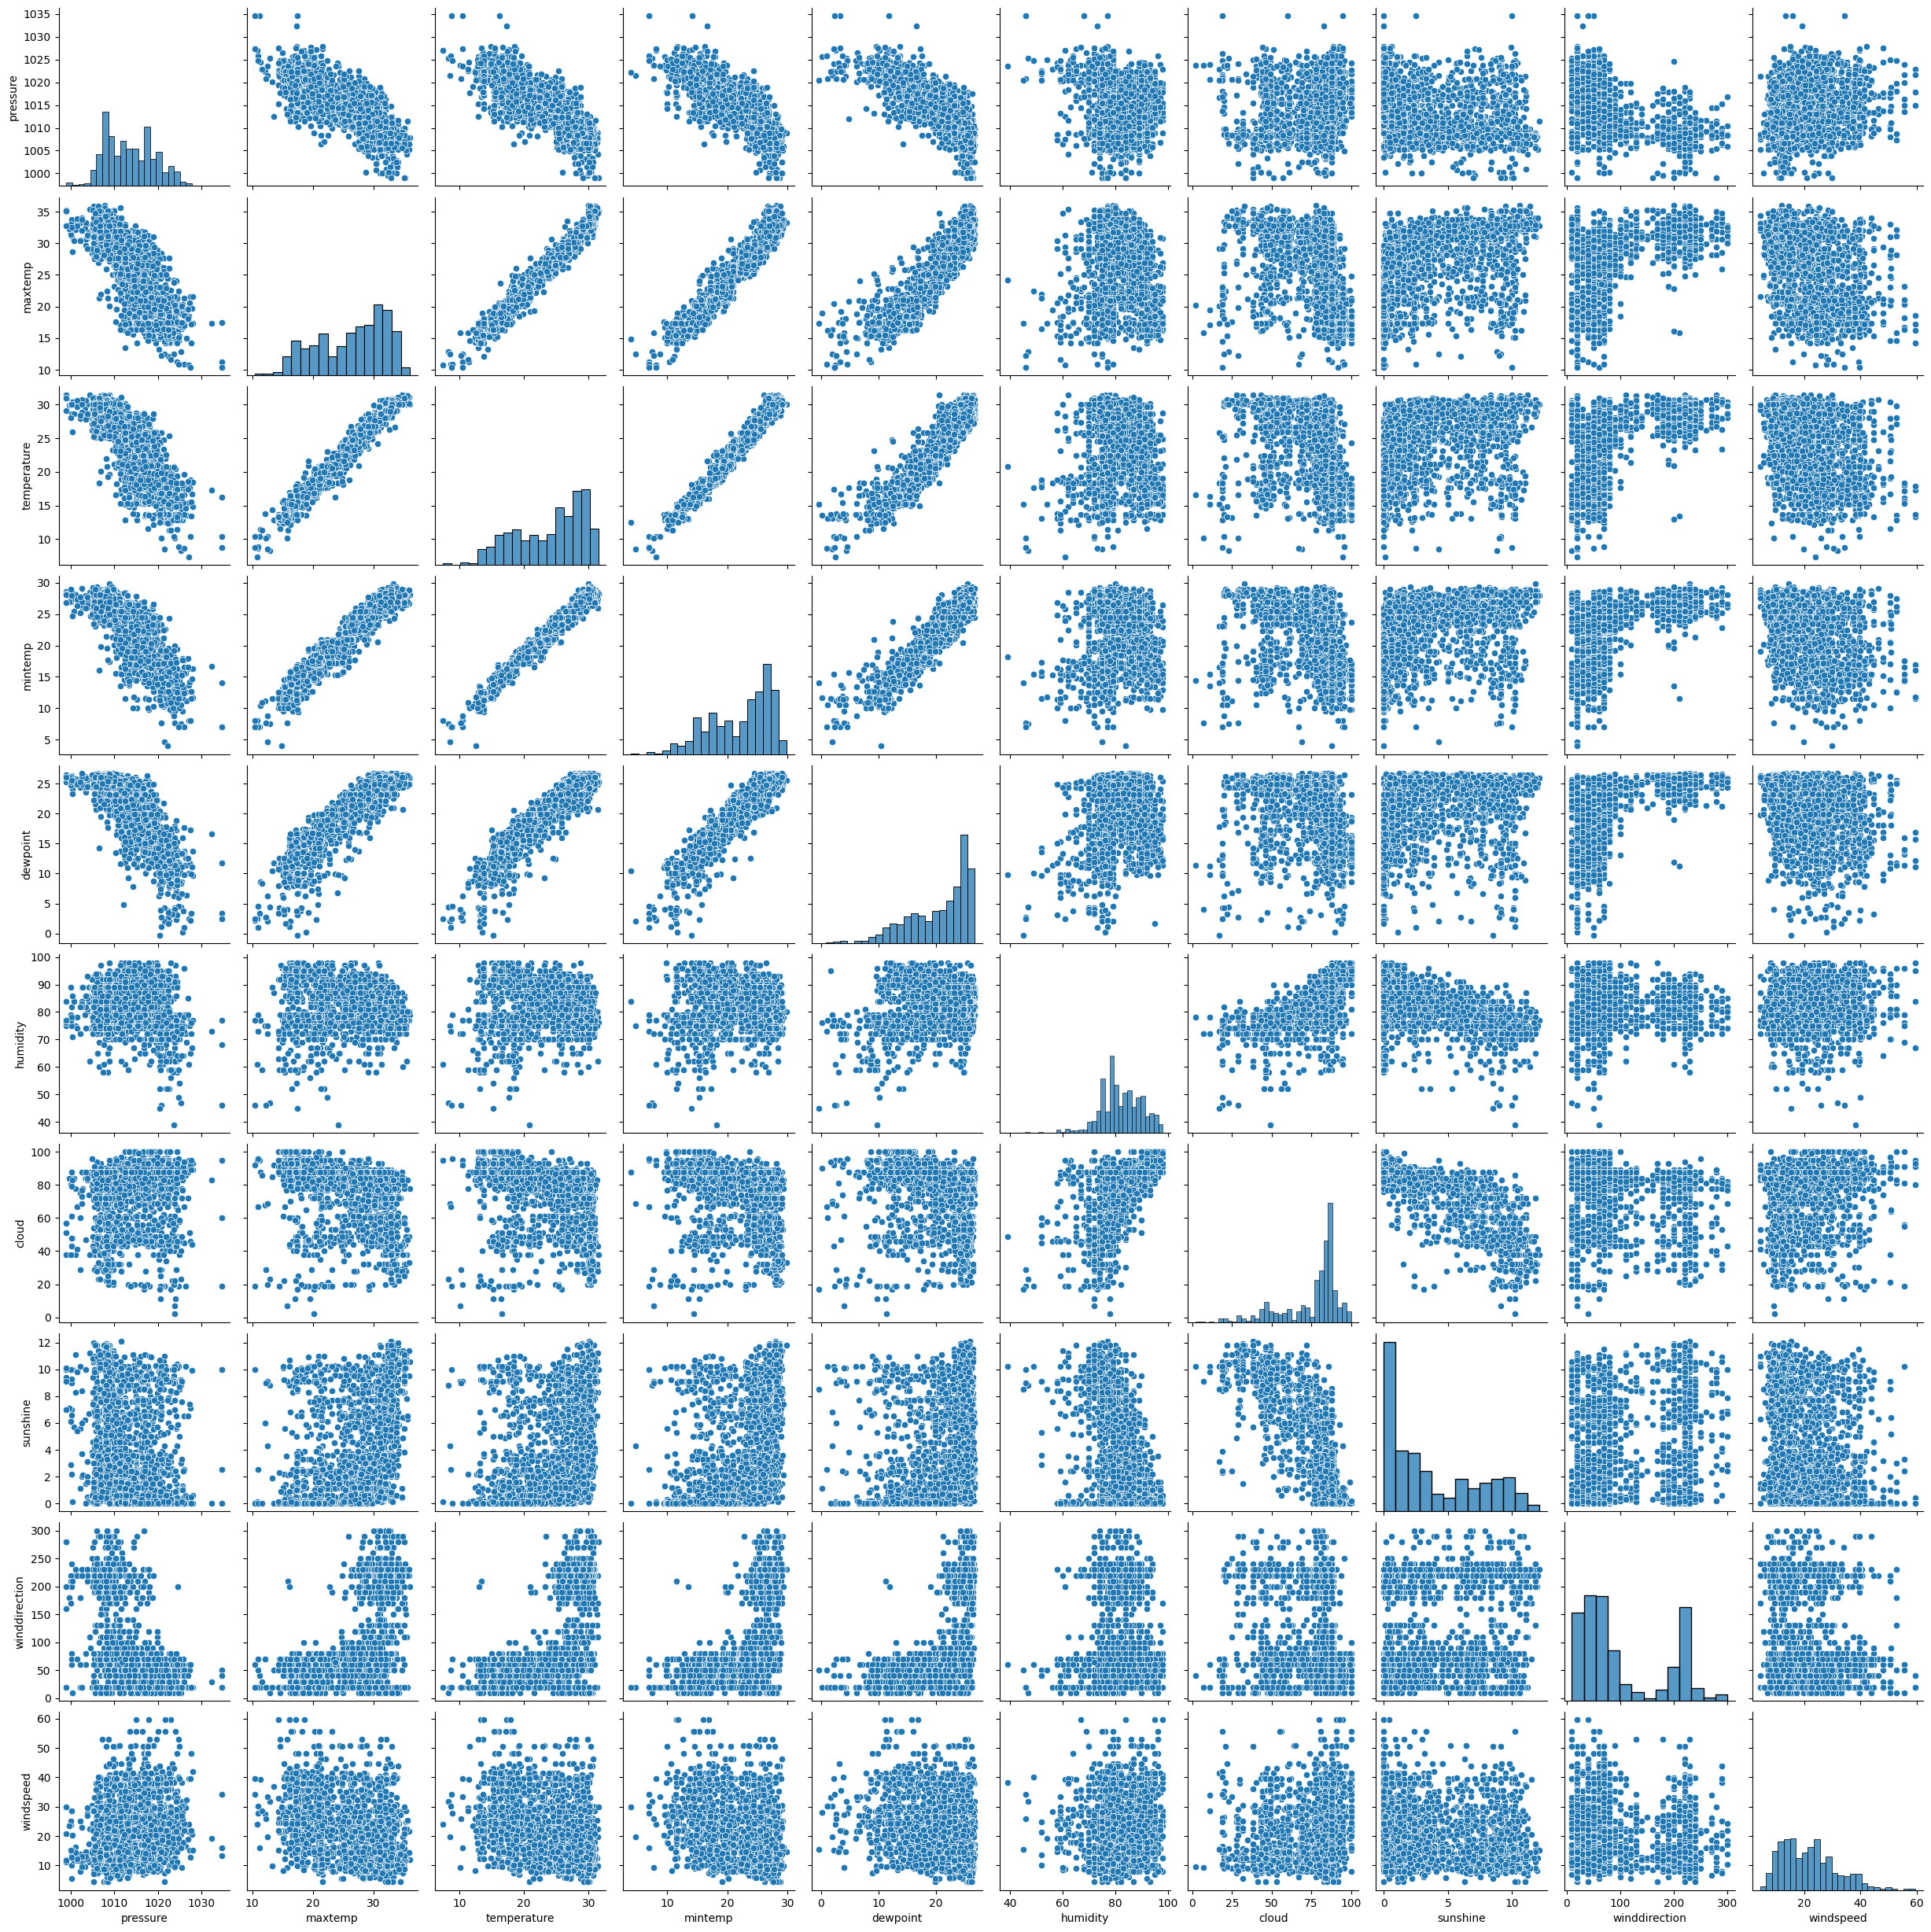

In [7]:
pgrid = sns.pairplot(train_df)
pgrid.savefig("pairgrid.png")

pgrid = None
gc.collect()

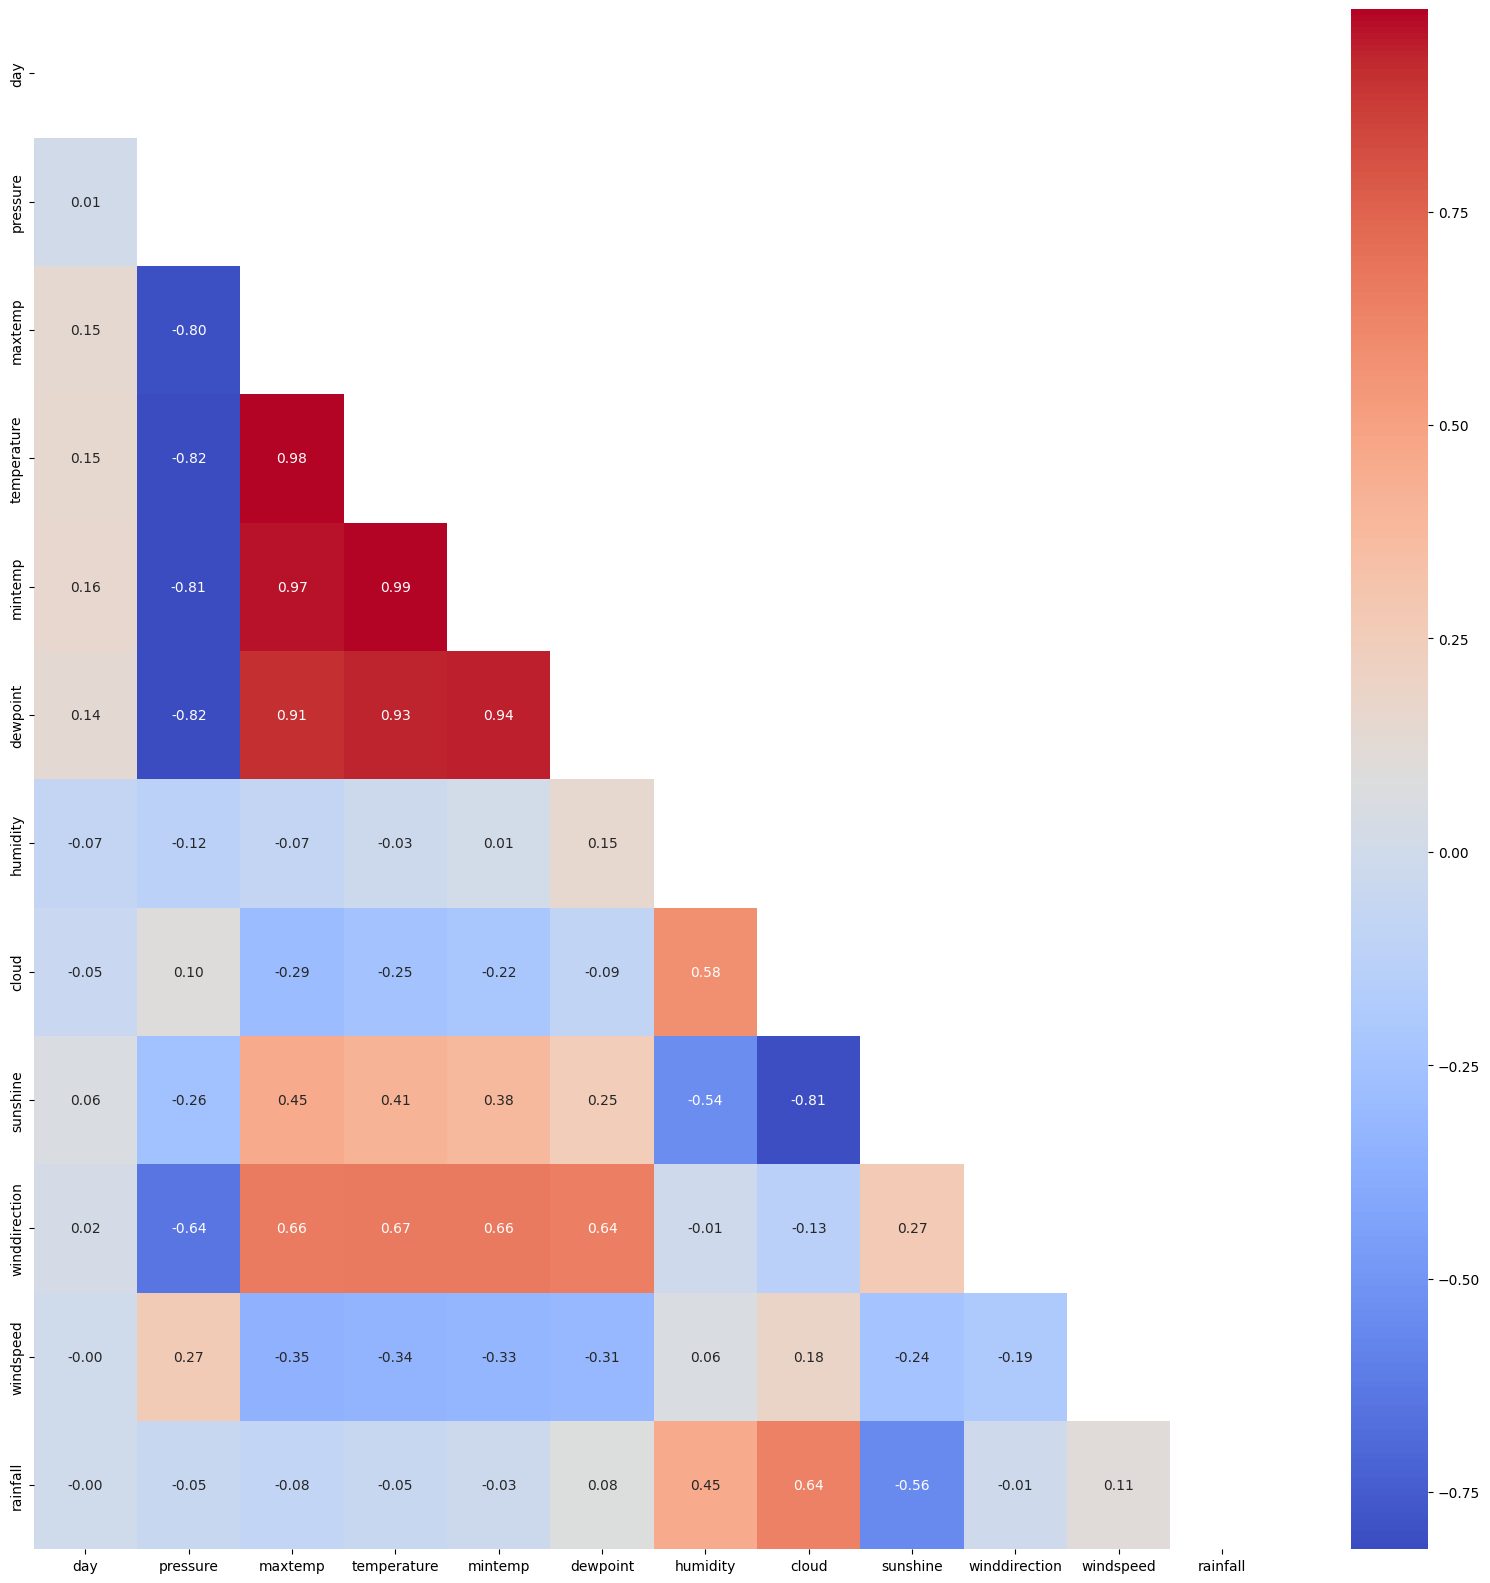

306636

In [8]:
corr_df = train_df

corr = corr_df.corr()
mask = np.triu(np.ones_like(corr))

plt.figure(figsize=(20, 20))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", mask=mask)
plt.show()

corr_df, corr, mask = None, None, None
gc.collect()

245

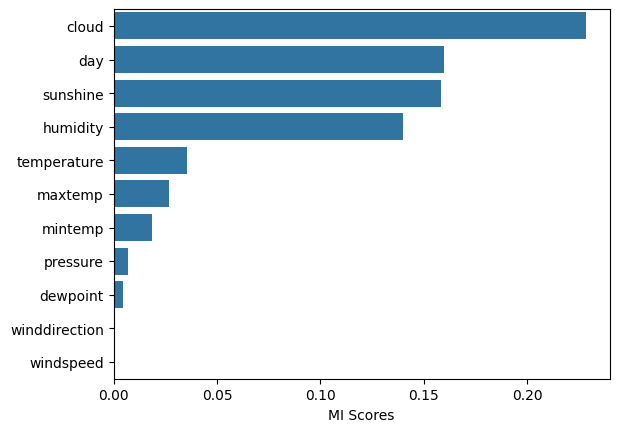

In [9]:
mi_df = train_df
mi_df["day"], _ = mi_df["day"].factorize()

x, y = mi_df.drop(columns=["rainfall"]), mi_df["rainfall"]

disc_feats = x.dtypes == np.int64

mi = mutual_info_classif(x, y, discrete_features=disc_feats)
mi = pd.Series(mi, name="MI Scores", index=x.columns)
mi = mi.sort_values(ascending=False)

sns.barplot(mi, orient="h")

mi_df, x, y, disc_feats = None, None, None, None
gc.collect()

In [15]:
time = train_df["day"]
y_value_cols = train_df.columns.drop("day")

sp_rows = 6
sp_cols = 2
sp_ids = [(r, c) for r in range(1, sp_rows + 1) for c in range(1, sp_cols + 1)]

traces = []
titles = []
sp_ind = 0

colors = px.colors.qualitative.Light24

for column in y_value_cols:
    traces.append(
        (
            go.Scatter(x=time, y=train_df[column], name=column, mode="markers", marker_size=1),
            sp_ids[sp_ind]
        )
    )

    titles.append(column)
    sp_ind += 1

fig = make_subplots(rows=sp_rows, cols=sp_cols, subplot_titles=titles)
for trace, sp in traces:
    fig.append_trace(trace, row=sp[0], col=sp[1])

fig.update_xaxes(categoryorder="category ascending")
fig.update_traces(dict(marker_line_width=0))
fig.update_layout(
    height=1000, 
    width=1000, 
    title_text="Summary of columns",
    template="plotly_dark")
fig.show()
gc.collect()

610

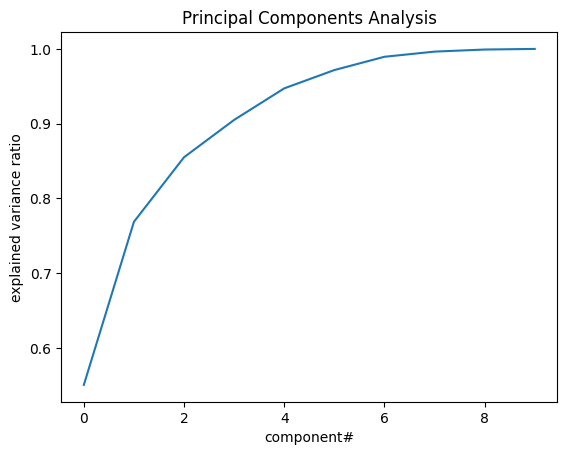

2868

In [43]:
normed_df = train_df.drop(columns=["day"])
normed_df["rainfall"] = normed_df["rainfall"].astype(int)
normed_df = (normed_df - normed_df.mean()) / normed_df.std()

pca = PCA()
pca.fit(normed_df.drop(columns=["rainfall"]))
plt.plot(pca.explained_variance_ratio_.cumsum())
plt.title('Principal Components Analysis')
plt.xlabel('component#')
plt.ylabel('explained variance ratio')
plt.show()

normed_df = None
gc.collect()

In [44]:
%%time
pca = PCA(n_components=3)
components = pca.fit_transform(train_df)

total_var = pca.explained_variance_ratio_.sum() * 100

fig = px.scatter(components, x=0, y=1, color=train_df["rainfall"])
fig.show()

fig = px.scatter_3d(
    components, x=0, y=1, z=2, color=train_df["rainfall"],
    title=f'Total Explained Variance: {total_var:.2f}%',
    labels={'0': 'PC 1', '1': 'PC 2', '2': 'PC 3'}
)
fig.show()

CPU times: total: 62.5 ms
Wall time: 66 ms


In [38]:
%%time
reducer = umap.UMAP()
embedding = reducer.fit_transform(train_df)

fig = px.scatter(x=embedding[:, 0], y=embedding[:, 1], color=train_df[TARGET_FEAT], title='Unsupervised UMAP projection of the training dataset', width=1000, height=1000)
fig.show()

CPU times: total: 7.69 s
Wall time: 2.65 s


In [51]:
%%time
kmeans = KMeans(n_clusters=3).fit(train_df)
train_df["cluster_id"] = kmeans.labels_

reducer = umap.UMAP()
embedding = reducer.fit_transform(train_df)

fig = px.scatter(x=embedding[:, 0], y=embedding[:, 1], color=train_df["cluster_id"], title='Unsupervised UMAP projection of the training dataset', width=1000, height=1000)
fig.show()

CPU times: total: 7.03 s
Wall time: 2.27 s
